In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from matplotlib import pyplot
import statistics
import pickle
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from copy import deepcopy

In [3]:
df = pd.read_csv('data_model.csv')

# Split the data

In [4]:
df.drop(columns=['directory'],inplace=True)

In [5]:
#Save splits
#Define features and target
X = df[[c for c in df.columns if c != "phish"]]
y = df["phish"]
#Scale the data
scaler = StandardScaler()
scaler.fit(X, y=y)
X = scaler.transform(X)
#Splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Split the data
for i,j in skf.split(X,y):
    with open('split.csv','a') as f:
        f.write(f"\n{list(i)},{list(j)}")

In [6]:
#Process splits into usable format
with open('split.csv','r') as f:
    splits = f.readlines()
splits = splits[1:]
splits = [i[:-1] for i in splits]
splits = [i.replace(' ','') for i in splits]
usable = []
for i in splits:
    to_process = i.split(']')
    train_index = to_process[0][1:]
    test_index = to_process[1][2:]
    usable.append((train_index.split(','),test_index.split(',')))

# Training run

In [10]:
#Objective function
def objective(space):
    clf=XGBClassifier(
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    precision_list = []
    recall_list = []
    f_score_list = []
    for train_index, test_index in usable:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        evaluation = [(X_test, y_test)]
        clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
        y_pred = clf.predict(X_test)
        precision,recall,f_score,support = precision_recall_fscore_support(y_test,y_pred,average='binary')
        precision_list.append(precision)
        recall_list.append(recall)
        f_score_list.append(f_score)
    precision = statistics.mean(precision_list)
    recall = statistics.mean(recall_list)
    f_score= statistics.mean(f_score_list)
    
    print (f"F1 score: {f_score}")
    return {'loss': -f_score, 'status': STATUS_OK }

In [12]:
def trainer(X,y,col_no):
        
    if col_no < 10:
        model = XGBClassifier(eval_metric="aucpr",scale_pos_weight=42)

    else:
        #Domain space
        space={'max_depth': hp.quniform("max_depth", 1, col_no, 1),
               'gamma': hp.uniform ('gamma', 1,9),
               'reg_alpha' : hp.quniform('reg_alpha', 0,1000,1),
               'reg_lambda' : hp.uniform('reg_lambda', 0,1),
               'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
               'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
               'seed': 42,
               'scale_pos_weight' : 42
              }
    
        #Optimization algo
        trials = Trials()

        #Best hyperparameters
        bh = fmin(fn = objective,
                  space = space,
                  algo = tpe.suggest,
                  max_evals = 500,
                  trials = trials)
        print(bh)
        
        #Model
        model = XGBClassifier(eval_metric="aucpr",scale_pos_weight=42,
                           colsample_bytree=bh['colsample_bytree'],gamma=bh['gamma'],
                             max_depth=int(bh['max_depth']), min_child_weight=int(bh['min_child_weight']),
                             reg_alpha=int(bh['reg_alpha']),reg_lambda=bh['reg_lambda'])

    y_true = []
    y_pred = []
    best_f1 = 0
    for train_index, test_index in usable:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train,
                  early_stopping_rounds=10,eval_set=[(X_train,y_train),(X_test,y_test)],
                  eval_metric=['aucpr'], verbose=False)
        y_pred_to_add = model.predict(X_test)
        y_true_to_add = y_test
        
        #Mini test to pickle the best
        _,_,f1,_ = precision_recall_fscore_support(y_true_to_add,y_pred_to_add,average='binary')
        if f1 > best_f1:
            best_f1 = f1
            filename = "htmlc.pkl"
            pickle.dump(model, open(filename, 'wb'), protocol=2)
        
        y_true.extend(y_true_to_add)
        y_pred.extend(y_pred_to_add)
    
    return y_true, y_pred

In [13]:
#Find best hyperparameters
X = df[[i for i in df.columns if i != 'phish']]
y = df['phish']
scaler = StandardScaler()
scaler.fit(X, y=y)
X_scaled = scaler.transform(X)
filename = "scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'), protocol=2)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X = X_scaled
y_true, y_pred = trainer(X,y,45)

F1 score: 0.03471504805737798                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.35019921714791835                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.07650360965894946                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.1156971121993643

F1 score: 0.14452641755793957                                                   
F1 score: 0.0                                                                   
F1 score: 0.1337698256666321                                                    
F1 score: 0.0                                                                   
F1 score: 0.6182471254566156                                                    
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.6007984203044728                                                    
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0019900497512437814                                                 
F1 score: 0.0                                                                   
F1 score: 0.0               

F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.07756250189478878                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.02542352657073455                                                   
F1 score: 0.5743298041425023                                                    
F1 score: 0.0                                                                   
F1 score: 0.0               

F1 score: 0.0                                                                   
F1 score: 0.3465942935429947                                                    
F1 score: 0.07789144618446767                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.4244924768949044                                                    
F1 score: 0.0                                                                   
F1 score: 0.5650748818116947                                                    
F1 score: 0.0                                                                   
F1 score: 0.00784313725490196                                                   
F1 score: 0.0                                                                   
F1 score: 0.05218772920804183                                                   
F1 score: 0.0               

F1 score: 0.4860552436231335                                                    
F1 score: 0.14567725264973558                                                   
F1 score: 0.13267959453255485                                                   
F1 score: 0.4195674647122929                                                    
F1 score: 0.164646428812119                                                     
F1 score: 0.49186904462310405                                                   
F1 score: 0.36904083616382377                                                   
F1 score: 0.03661890787267517                                                   
F1 score: 0.13571702918320028                                                   
F1 score: 0.4154632991864189                                                    
F1 score: 0.09080248544572747                                                   
F1 score: 0.09080248544572747                                                   
F1 score: 0.3579736161213627

In [14]:
#Retrieve report
precision,recall,f1,_ = precision_recall_fscore_support(y_true,y_pred,average='binary')
support = len([i for i in y_true if i == 1])
cm = list(confusion_matrix(y_true,y_pred).ravel())
    
print(f'\n0,,{f1},{precision},{recall},{support},{cm}')


0,,0.7920377160817182,0.8344370860927153,0.7537387836490529,1003,[42921, 150, 247, 756]


In [15]:
bh = {'colsample_bytree': 0.5451979490273768, 'gamma': 2.0563621530604443, 'max_depth': 27.0, 'min_child_weight': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 0.7283075035726418}

In [18]:
 model = XGBClassifier(eval_metric="aucpr",scale_pos_weight=42,
                       colsample_bytree=bh['colsample_bytree'],gamma=bh['gamma'],
                       max_depth=int(bh['max_depth']), min_child_weight=int(bh['min_child_weight']),
                       reg_alpha=int(bh['reg_alpha']),reg_lambda=bh['reg_lambda'])
train_index,test_index = usable[0]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train,y_train,
          early_stopping_rounds=2,eval_set=[(X_train,y_train),(X_test,y_test)],
          eval_metric=['aucpr'], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5451979490273768,
              enable_categorical=False, eval_metric='aucpr',
              gamma=2.0563621530604443, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=27, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.7283075035726418, scale_pos_weight=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

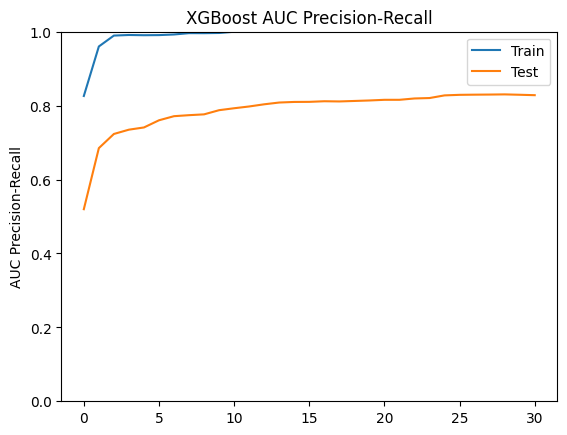

In [19]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.set_ylim([0, 1])
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
pyplot.ylabel('AUC Precision-Recall')
pyplot.title('XGBoost AUC Precision-Recall')
pyplot.show()